# HW2-3 Image captioning

### Library

In [1]:
!pip install unsloth pandas pyarrow torch torchvision datasets transformers accelerate bitsandbytes

In [2]:
import pandas as pd
from PIL import Image as PILImage
from datasets import Dataset, Features, Image, Value
import torch
from torchvision import transforms
from unsloth import FastVisionModel
import json

from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

from transformers import TextStreamer
from tqdm import tqdm

import gc

device = "cuda" if torch.cuda.is_available() else "cpu"

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Dataset

In [3]:
def prepare_dataset(parquet_file, include_caption=True):
    df = pd.read_parquet(parquet_file)
    df['image'] = df['image'].apply(lambda x: x['bytes'])  # flatten {'bytes': ...}

    features = Features({
        'image': Image(decode=True),
        'caption': Value('string') if include_caption else Value('null')  # null type if test set
    })

    columns = ['image', 'caption'] if include_caption else ['image']
    dataset = Dataset.from_pandas(df[columns], features=features)

    def resize_image(example):
        img = example['image']
        if isinstance(img, PILImage.Image):
            img = img.resize((224, 224))
        return {'image': img}

    dataset = dataset.map(resize_image)
    return dataset

train_ds = prepare_dataset("train_data.parquet", include_caption=True)
valid_ds = prepare_dataset("valid_data.parquet", include_caption=True)

test_df = pd.read_parquet("test_data.parquet")
test_df['image'] = test_df['image'].apply(lambda x: x['bytes'])

# Test dataset: build Hugging Face Dataset (with idx)
features_test = Features({
    'idx': Value('int64'),
    'image': Image(decode=True)
})
test_ds = Dataset.from_pandas(test_df[['idx', 'image']], features=features_test)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [19]:
import random
import matplotlib.pyplot as plt
import math

def show_random_samples(dataset, num_samples=6, cols=3):
    """
    Randomly samples and displays images + captions in subplots.

    Args:
        dataset: Hugging Face Dataset with 'image' and 'caption' columns.
        num_samples: Total number of random samples to display.
        cols: Number of columns in the grid.
    """
    print(f"\n📊 Sampling {num_samples} random samples from dataset (size: {len(dataset)})...\n")
    samples = random.sample(list(dataset), num_samples)

    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # If num_samples < cols, axes might not be 2D
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]

    for i, sample in enumerate(samples):
        row_idx = i // cols
        col_idx = i % cols

        ax = axes[row_idx][col_idx] if rows > 1 else axes[col_idx]

        img = sample['image']
        caption = sample['caption']

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{caption}", fontsize=9)

    # Hide any empty subplots if num_samples < rows * cols
    for j in range(num_samples, rows * cols):
        row_idx = j // cols
        col_idx = j % cols
        ax = axes[row_idx][col_idx] if rows > 1 else axes[col_idx]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


📊 Sampling 4 random samples from dataset (size: 200)...



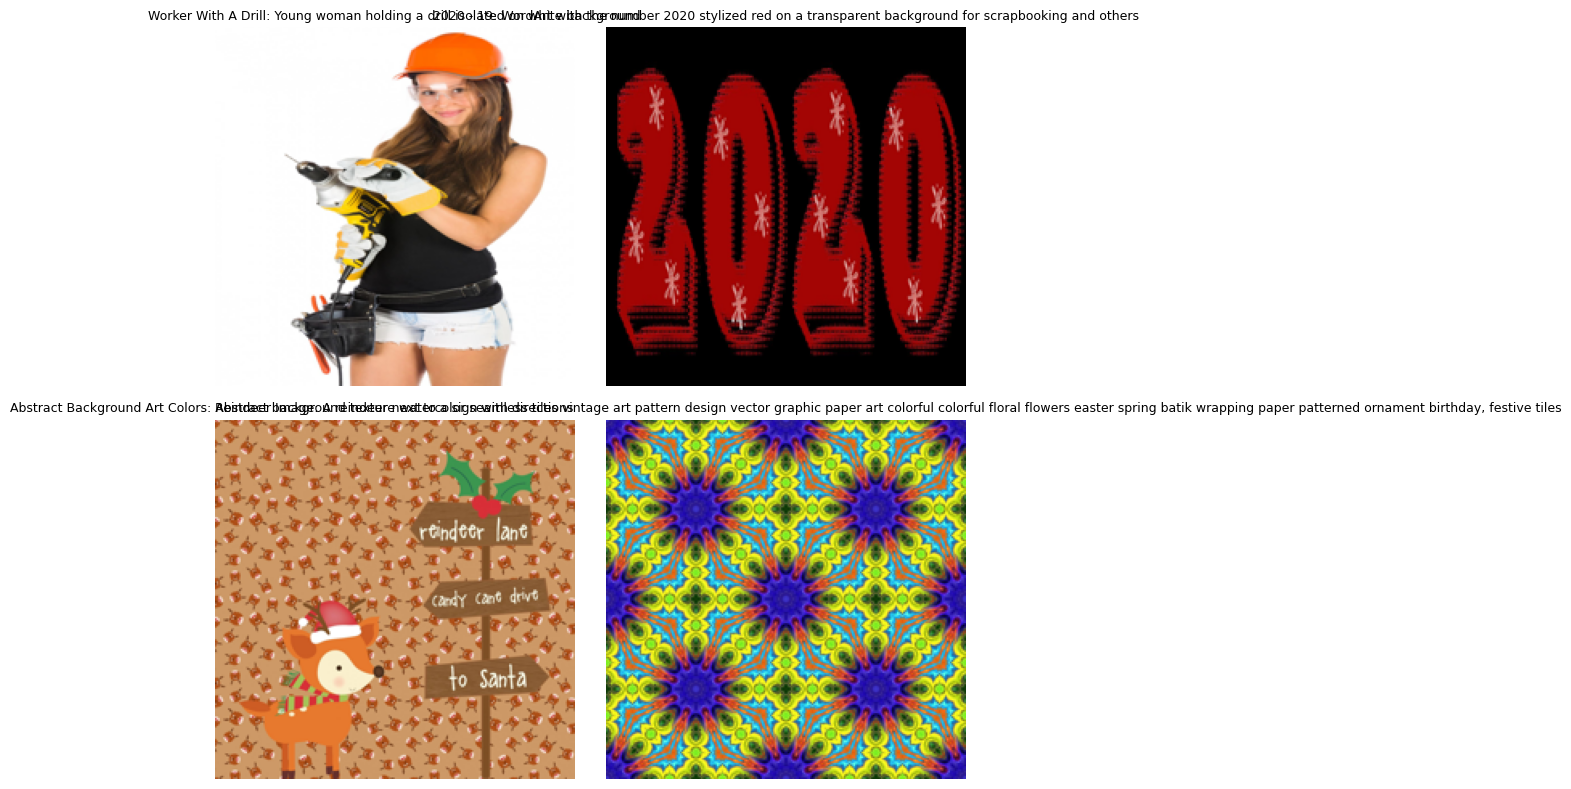


📊 Sampling 4 random samples from dataset (size: 100)...



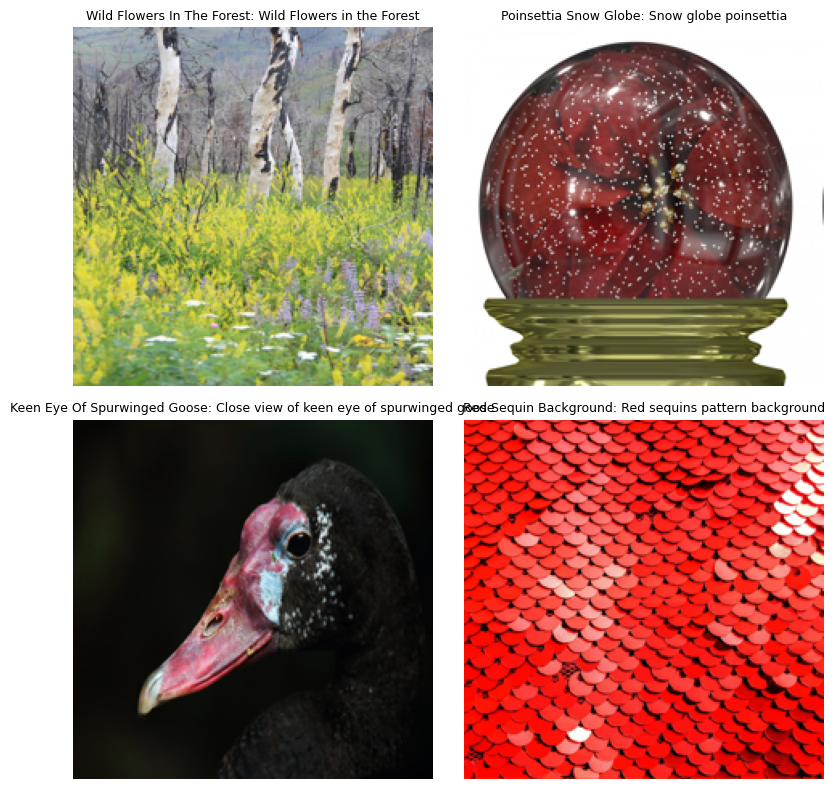

In [20]:
show_random_samples(train_ds, num_samples=4, cols=2)
show_random_samples(valid_ds, num_samples=4, cols=2)

### Pretrained model

In [9]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.4.7: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Finetuning

In [10]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


### Prompting

In [21]:
instruction = (
    "You are an expert in stock-photo and design description. Write a precise caption for this image mentioning "
    "the main subject, key visual elements."
)

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

converted_dataset = [convert_to_conversation(sample) for sample in train_ds]

### Training

In [12]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 200 | Num Epochs = 2 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 52,428,800/11,000,000,000 (0.48% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,4.389200
2,4.133500
3,4.132500
4,3.988700
5,3.540900
6,3.068800
7,2.305400
8,1.869900
9,1.556200
10,1.206600


### Saving

In [15]:
model.save_pretrained("Llama-3.2-11B-Vision-caption-finetune-unsloth") # Local saving
tokenizer.save_pretrained("Llama-3.2-11B-Vision-caption-finetune-unsloth")
model.push_to_hub("Wilbur1240/Llama-3.2-11B-Vision-caption-finetune-unsloth-v2") # Online saving
tokenizer.push_to_hub("Wilbur1240/Llama-3.2-11B-Vision-caption-finetune-unsloth-v2") # Online saving

README.md:   0%|          | 0.00/633 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/210M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Wilbur1240/Llama-3.2-11B-Vision-caption-finetune-unsloth-v2


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

### Inference

In [4]:
from huggingface_hub import login
login()

In [8]:
gc.collect()
torch.cuda.empty_cache()

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "Wilbur1240/Llama-3.2-11B-Vision-caption-finetune-unsloth", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)

### Inference on valication dataset

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [16]:
FastVisionModel.for_inference(model)
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

results = []

instruction = (
    "You are an expert in stock-photo and design description. Write a precise caption for this image mentioning "
    "the main subject, key visual elements."
)

for i, example in tqdm(enumerate(valid_ds), total=len(valid_ds)):
    image = example['image']
    # If no 'idx', use row number
    idx = example.get('idx', i)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=True,
        return_tensors="pt",
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        use_cache=True,
        temperature=0.3,
        top_p=0.9,
    )

    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
    instruction_marker = (instruction + "assistant\n\n").strip()
    if instruction_marker in caption:
        caption = caption.split(instruction_marker)[-1].strip()

    results.append({
        "idx": idx,
        "output": caption.strip()
    })

# Save results for BLEU eval
with open('validation_inference.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Inference complete. Saved to validation_inference.json.")

100%|██████████| 100/100 [14:18<00:00,  8.58s/it]

✅ Inference complete. Saved to validation_inference.json.


In [11]:
print("BOS token:", tokenizer.bos_token, tokenizer.bos_token_id)
print("EOS token:", tokenizer.eos_token, tokenizer.eos_token_id)
print("PAD token:", tokenizer.pad_token, tokenizer.pad_token_id)

BOS token: <|begin_of_text|> 128000
EOS token: <|eot_id|> 128009
PAD token: <|finetune_right_pad_id|> 128004


### BLEU score on validation dataset

In [17]:
import json
import string
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

# Normalize text helper
def normalize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Load inference results
with open('validation_inference.json', 'r', encoding='utf-8') as f:
    inference_results = json.load(f)

references = []
hypotheses = []

smoothing_function = SmoothingFunction().method1

unique_indices = set()

for item in tqdm(inference_results, total=len(inference_results)):
    idx = item["idx"]

    if idx in unique_indices:
        print(f"idx {idx} already processed.")
        continue  # skip duplicate

    unique_indices.add(idx)

    generated_caption = normalize_text(item["output"])

    # Get the standard caption from valid_ds
    # If your valid_ds has 'idx' column, use that to find the right row:
    if 'idx' in valid_ds.features:
        # Find the matching row by idx
        match = next((ex for ex in valid_ds if ex['idx'] == idx), None)
        if match is None:
            print(f"Warning: idx {idx} not found in valid_ds!")
            continue
        standard_caption = normalize_text(match['caption'])
    else:
        # fallback: assume idx == row number
        standard_caption = normalize_text(valid_ds[idx]['caption'])

    references.append([standard_caption.split()])
    hypotheses.append(generated_caption.split())

# Calculate BLEU
corpus_bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing_function)
print("Corpus BLEU score: {:.4f}".format(corpus_bleu_score))


100%|██████████| 100/100 [00:00<00:00, 468.21it/s]

Corpus BLEU score: 0.0207


### Inference on test dataset

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

text_streamer = TextStreamer(tokenizer, skip_prompt=True)

results = []

instruction = (
    "You are an expert in stock-photo and design description. Write a precise caption for this image mentioning "
    "the main subject, key visual elements."
)

for example in tqdm(test_ds):
    image = example['image']
    idx = example['idx']

    # Build the chat prompt
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    # Prepare inputs
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate the caption
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        use_cache=True,
        temperature=1.5,
        min_p=0.1,
    )

    # Decode
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
    instruction_marker = (instruction + "assistant\n\n").strip()
    if instruction_marker in caption:
        caption = caption.split(instruction_marker)[-1].strip()

    # Collect result
    results.append({
        "idx": idx,
        "output": caption.strip()
    })

# 4️⃣ Save results to JSON (like sample_submission.json)
with open('submission.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Inference complete. Results saved to submission.json.")

==((====))==  Unsloth 2025.4.7: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:05<00:00,  4.26s/it]

✅ Inference complete. Results saved to submission.json.
